#I. EDA


#1. Nạp và tiền xử lý dữ liệu

In [ ]:


# 2. Import các thư viện
import warnings
warnings.filterwarnings('ignore')

# Import Neccessary libraries
import numpy as np
import pandas as pd

# Import Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import Model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Import Sampler libraries (Phần hay gây lỗi nếu chưa cài đặt ở bước 1)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

# Set the decimal format
pd.options.display.float_format = "{:.2f}".format

print("Đã import thành công tất cả thư viện!")

Đã import thành công tất cả thư viện!


##1.1. In 5 dòng đầu

In [ ]:
from google.colab import files
import io
import pandas as pd

# 1. Tải file diabetes_prediction_dataset.csv từ máy của bạn lên
print("Vui lòng upload file diabetes_prediction_dataset.csv:")
uploaded = files.upload()

# 2. Lấy tên file và đọc
filename = next(iter(uploaded))
df = pd.read_csv(io.BytesIO(uploaded[filename]))

# Hiển thị 5 dòng đầu để kiểm tra
print(df.head())


Vui lòng upload file diabetes_prediction_dataset.csv:


Saving diabetes_prediction_dataset.csv to diabetes_prediction_dataset.csv
   gender   age  hypertension  heart_disease smoking_history   bmi  \
0  Female 80.00             0              1           never 25.19   
1  Female 54.00             0              0         No Info 27.32   
2    Male 28.00             0              0           never 27.32   
3  Female 36.00             0              0         current 23.45   
4    Male 76.00             1              1         current 20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0         6.60                  140         0  
1         6.60                   80         0  
2         5.70                  158         0  
3         5.00                  155         0  
4         4.80                  155         0  


##1.2. Xử lý dữ liệu

###1.2.1. Xử lý dữ liệu trùng lặp

In [ ]:
# Handle duplicates
duplicate_rows_data = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_data.shape)

number of duplicate rows:  (3854, 9)


In [ ]:
df = df.drop_duplicates()

###1.2.2 Xử lý riêng biệt

In [ ]:
# Loop through each column and count the number of distinct values
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

gender: 3 distinct values
age: 102 distinct values
hypertension: 2 distinct values
heart_disease: 2 distinct values
smoking_history: 6 distinct values
bmi: 4247 distinct values
HbA1c_level: 18 distinct values
blood_glucose_level: 18 distinct values
diabetes: 2 distinct values


###1.2.3. Xử lý giá trị thiếu

In [ ]:
# Checking null values
print(df.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [ ]:
# Remove Unneccessary value [0.00195%]
df = df[df['gender'] != 'Other']

###1.2.4. Mô tả dữ liệu

In [ ]:
df.describe().style.format("{:.2f}")

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96128.00,96128.00,96128.00,96128.00,96128.00,96128.00,96128.00
mean,41.80,0.08,0.04,27.32,5.53,138.22,0.09
std,22.46,0.27,0.20,6.77,1.07,40.91,0.28
min,0.08,0.00,0.00,10.01,3.50,80.00,0.00
25%,24.00,0.00,0.00,23.40,4.80,100.00,0.00
50%,43.00,0.00,0.00,27.32,5.80,140.00,0.00
75%,59.00,0.00,0.00,29.86,6.20,159.00,0.00
max,80.00,1.00,1.00,95.69,9.00,300.00,1.00


#

##2. Xử lý đơn biến

###2.1  Histogram về tuổi

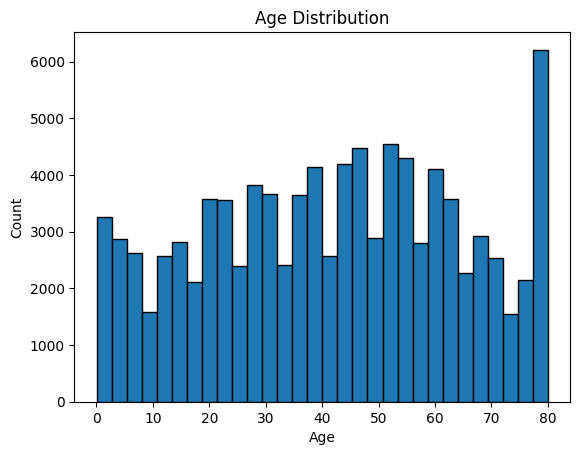

In [ ]:
# Histogram for age
plt.hist(df['age'], bins=30, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

###2.2. Biểu đồ cột giới tính

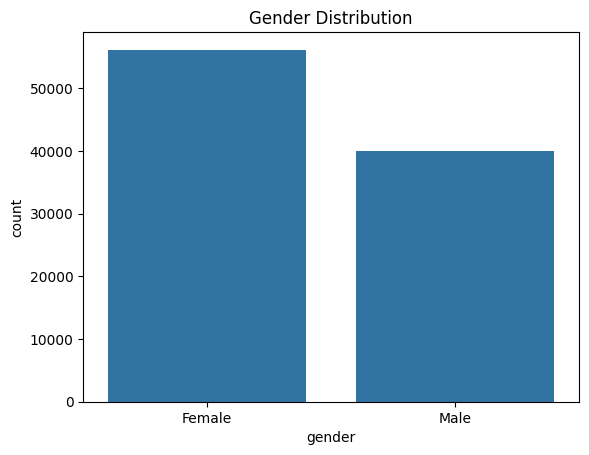

In [ ]:
# Bar plot for gender
sns.countplot(x='gender', data=df)
plt.title('Gender Distribution')
plt.show()

###2.3. Biểu đồ phân phối của BMI

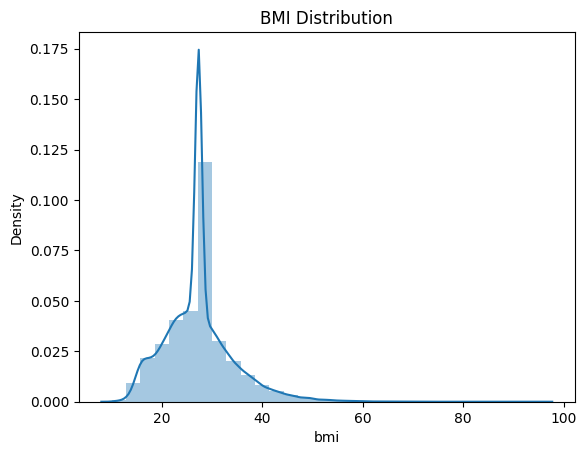

In [ ]:
# Distribution plot for BMI
sns.distplot(df['bmi'], bins=30)
plt.title('BMI Distribution')
plt.show()

###2.4.  Biểu đồ tần suất cho biến nhị phân

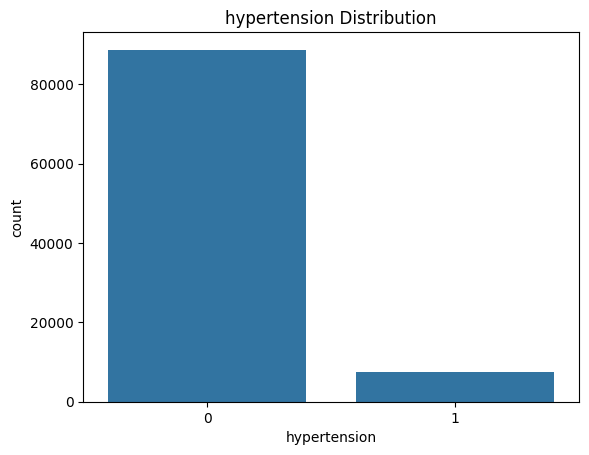

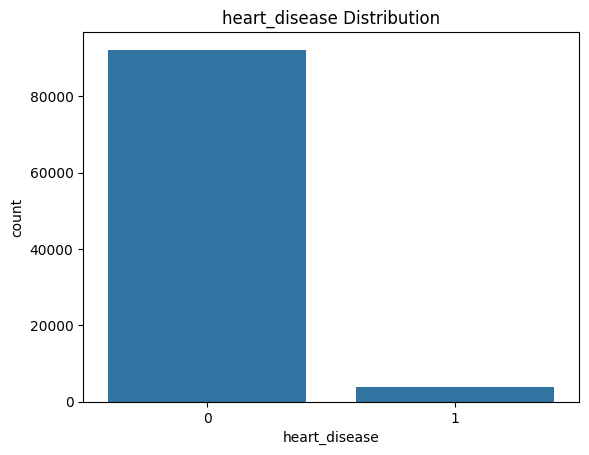

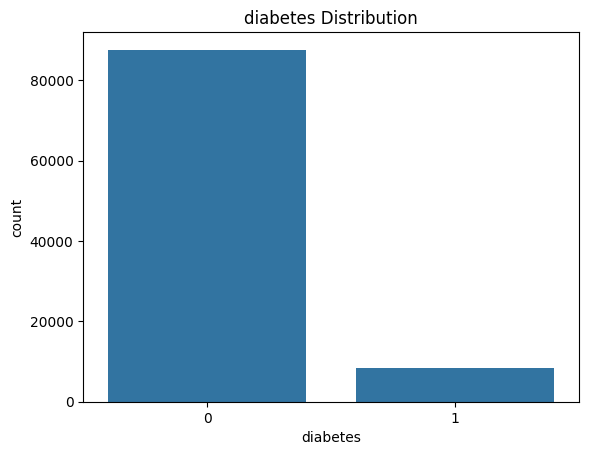

In [ ]:
# Count plots for binary variables
for col in ['hypertension', 'heart_disease', 'diabetes']:
    sns.countplot(x=col, data=df)
    plt.title(f'{col} Distribution')
    plt.show()

###2.5. Biểu đồ đếm theo tiền sử hút thuốc

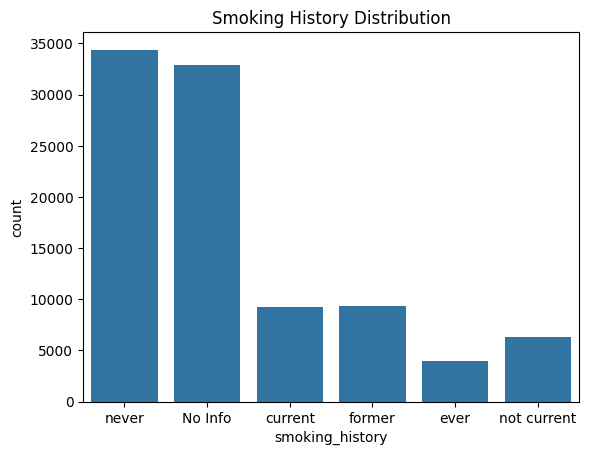

In [ ]:
# Count plot for smoking history
sns.countplot(x='smoking_history', data=df)
plt.title('Smoking History Distribution')
plt.show()

#II. Hệ số tương quan

##1. Chuẩn bị dữ liệu

In [ ]:
# Define a function to map the existing categories to new ones
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 'non-smoker'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'

# Apply the function to the 'smoking_history' column
df['smoking_history'] = df['smoking_history'].apply(recategorize_smoking)

# Check the new value counts
print(df['smoking_history'].value_counts())

smoking_history
non-smoker     67276
past_smoker    19655
current         9197
Name: count, dtype: int64


In [ ]:
data = df.copy()

#2. Mã hóa

In [ ]:
def perform_one_hot_encoding(df, column_name):
    # Perform one-hot encoding on the specified column
    dummies = pd.get_dummies(df[column_name], prefix=column_name)

    # Drop the original column and append the new dummy columns to the dataframe
    df = pd.concat([df.drop(column_name, axis=1), dummies], axis=1)

    return df

# Perform one-hot encoding on the gender variable
data = perform_one_hot_encoding(data, 'gender')

# Perform one-hot encoding on the smoking history variable
data = perform_one_hot_encoding(data, 'smoking_history')

##3. Ma trận tương quan

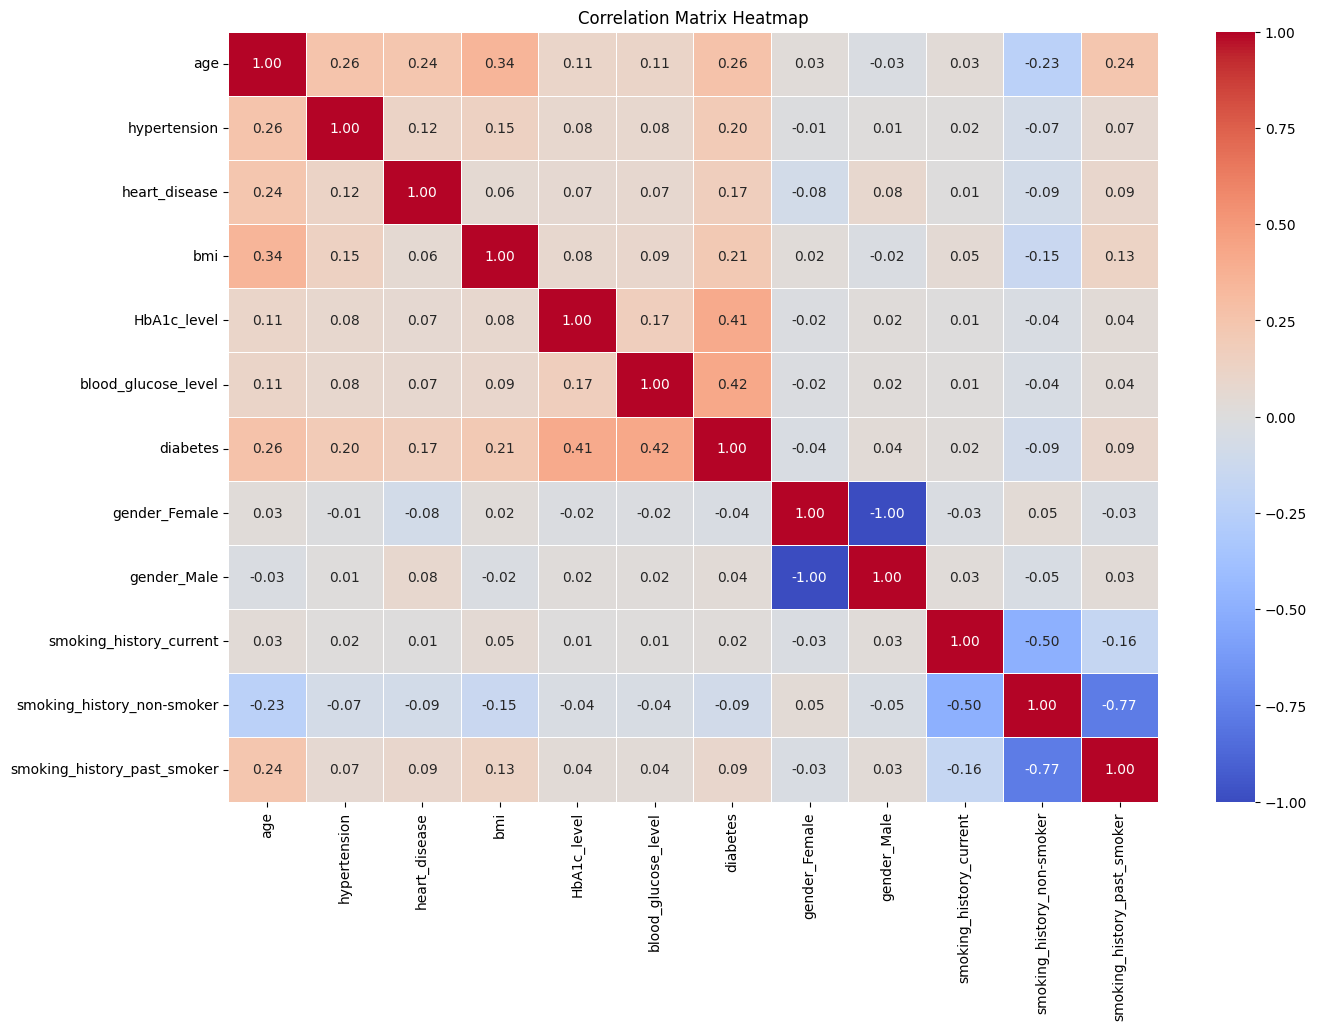

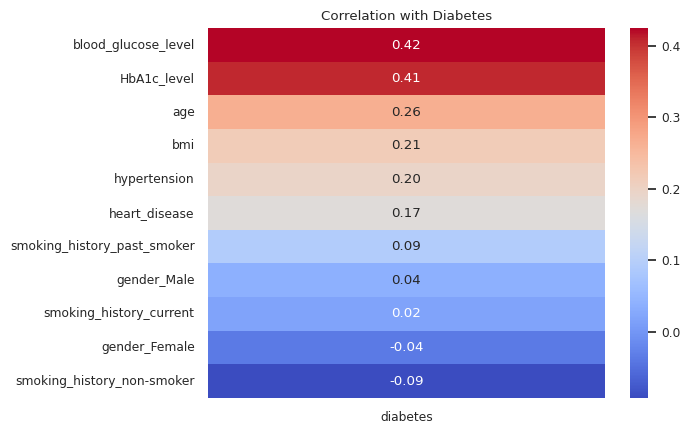

In [ ]:
# Compute the correlation matrix
correlation_matrix = data.corr()
#Graph I.
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()


#Graph II
# Create a heatmap of the correlations with the target column
corr = data.corr()
target_corr = corr['diabetes'].drop('diabetes')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Diabetes')
plt.show()

#III. Phân tích dự đoán

##1. Mất cân bằng giữa các lớp

**Từ phân tích khám phá dữ liệu (EDA), tập dữ liệu bị mất cân bằng (với 9% ca dương tính mắc tiểu đường và 91% ca âm tính), vì vậy việc cân bằng dữ liệu là rất quan trọng để đảm bảo mô hình không thiên về lớp chiếm đa số. Vì mục đích này, kỹ thuật Over-sampling cho lớp thiểu số tổng hợp (SMOTE) được sử dụng, kỹ thuật này tạo ra các mẫu tổng hợp cho lớp thiểu số.**

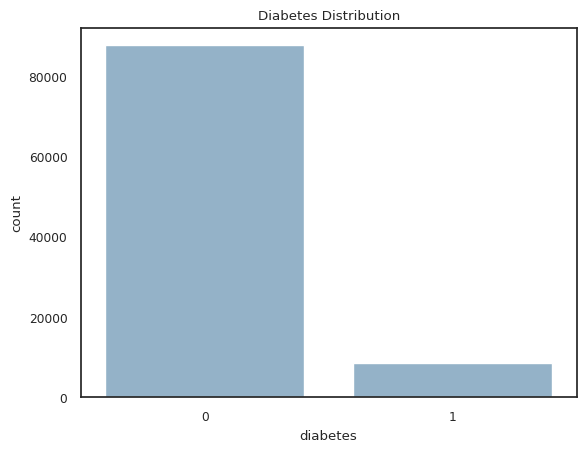

In [ ]:
# Count plot for the 'diabetes' variable
sns.countplot(x='diabetes', data=df)
plt.title('Diabetes Distribution')
plt.show()

In [ ]:
# Define resampling
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

##2. Tiền xử lý SVM

In [ ]:
# --- BƯỚC 3.2: CHUẨN BỊ DỮ LIỆU (DATA PREPROCESSING) ---

from sklearn.svm import SVC # Import thêm SVM

# 1. Tách biến độc lập (X) và biến mục tiêu (y)
X = df.drop('diabetes', axis=1)
y = df['diabetes']

# 2. Chia tập Train/Test (80% Train, 20% Test)
# Stratify=y để đảm bảo tỉ lệ người bệnh ở 2 tập là như nhau
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Định nghĩa lại Preprocessor (Chuẩn hóa cho SVM)
# Lưu ý: SVM rất nhạy cảm với khoảng cách, StandardScaler là bắt buộc.
# OneHotEncoder thêm drop='first' để tránh đa cộng tuyến và giảm chiều dữ liệu.

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'hypertension', 'heart_disease']),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), ['gender', 'smoking_history'])
    ])

print("Đã hoàn tất chia dữ liệu và thiết lập bộ xử lý.")
print(f"Kích thước tập Train: {X_train.shape}")
print(f"Kích thước tập Test: {X_test.shape}")

Đã hoàn tất chia dữ liệu và thiết lập bộ xử lý.
Kích thước tập Train: (76902, 8)
Kích thước tập Test: (19226, 8)


##3. Xây dựng mô hình

**Chúng ta sẽ dùng imbPipeline để kết hợp: Tiền xử lý -> SMOTE (Over) -> Under Sampling -> SVM, sau đó dùng GridSearchCV để tìm tham số tốt nhất.**

In [ ]:
# --- BƯỚC 3.3: XÂY DỰNG VÀ TỐI ƯU HÓA MÔ HÌNH SVM ---

# 1. Tạo Pipeline tổng hợp
# Quy trình: Xử lý cột -> Tăng mẫu (Over) -> Giảm mẫu (Under) -> Mô hình SVM
svm_pipeline = imbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('over', over),   # Sử dụng biến over bạn đã định nghĩa ở 3.1
    ('under', under), # Sử dụng biến under bạn đã định nghĩa ở 3.1
    ('svm', SVC(probability=True, random_state=42)) # probability=True để vẽ đường cong ROC sau này
])

# 2. Thiết lập lưới tham số để tinh chỉnh (Hyperparameter Tuning)
# SVM chạy khá chậm trên dữ liệu lớn, nên ta chọn các tham số tiêu biểu nhất.
param_grid = {
    'svm__C': [0.1, 1, 10],           # Tham số phạt lỗi (Regularization)
    'svm__kernel': ['linear', 'rbf']  # Các loại hàm nhân phổ biến
}

# 3. Chạy GridSearchCV
print("Đang huấn luyện và tìm tham số tối ưu cho SVM... (Quá trình này có thể mất 3-5 phút)")

grid_search = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid,
    cv=3,                 # Kiểm tra chéo 3 lần
    scoring='accuracy',   # Đánh giá dựa trên độ chính xác
    n_jobs=-1,            # Sử dụng tất cả nhân CPU để chạy nhanh hơn
    verbose=2             # Hiển thị tiến trình
)

grid_search.fit(X_train, y_train)

# 4. Lưu mô hình tốt nhất
best_model = grid_search.best_estimator_

print("\n--- HUẤN LUYỆN HOÀN TẤT ---")
print(f"Tham số tốt nhất (Best Params): {grid_search.best_params_}")
print(f"Độ chính xác tốt nhất trên tập Train (Best CV Score): {grid_search.best_score_:.4f}")

Đang huấn luyện và tìm tham số tối ưu cho SVM... (Quá trình này có thể mất 3-5 phút)
Fitting 3 folds for each of 6 candidates, totalling 18 fits

--- HUẤN LUYỆN HOÀN TẤT ---
Tham số tốt nhất (Best Params): {'svm__C': 10, 'svm__kernel': 'rbf'}
Độ chính xác tốt nhất trên tập Train (Best CV Score): 0.9386


##4. Confusion Matrix

-------------------------------------------------------
Model Accuracy (Độ chính xác): 0.9352
-------------------------------------------------------

Classification Report (Báo cáo phân loại chi tiết):
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     17530
           1       0.60      0.81      0.69      1696

    accuracy                           0.94     19226
   macro avg       0.79      0.88      0.83     19226
weighted avg       0.95      0.94      0.94     19226



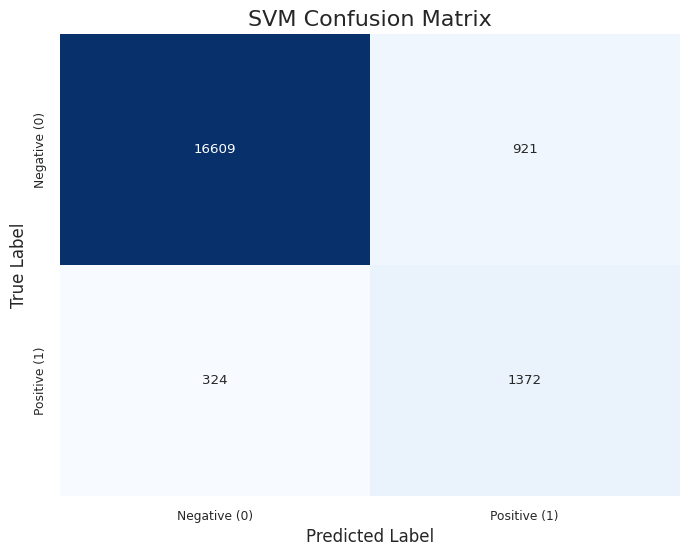

In [ ]:
# --- BƯỚC 3.4: MODEL EVALUATION (ĐÁNH GIÁ MÔ HÌNH) ---

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Dự đoán trên tập kiểm tra (Test set) bằng mô hình tốt nhất tìm được
y_pred = best_model.predict(X_test)

# 2. Tính toán và in các chỉ số đánh giá cơ bản
print("-------------------------------------------------------")
print(f"Model Accuracy (Độ chính xác): {accuracy_score(y_test, y_pred):.4f}")
print("-------------------------------------------------------")
print("\nClassification Report (Báo cáo phân loại chi tiết):")
print(classification_report(y_test, y_pred))

# 3. Vẽ Confusion Matrix (Ma trận nhầm lẫn)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
# Dùng heatmap của seaborn để vẽ cho đẹp
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative (0)', 'Positive (1)'],
            yticklabels=['Negative (0)', 'Positive (1)'])

plt.title('SVM Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

1. Confusion Matrix: Ma trận này giúp trực quan hiệu suất của mô hình bằng cách so sánh nhãn thực tế (Actual) và nhãn dự đoán (Predicted).

 * True Negative (TN): Thực tế KHÔNG bị bệnh, mô hình đoán ĐÚNG là không.

 * False Positive (FP - Type I Error): Thực tế KHÔNG bị bệnh, nhưng mô hình đoán SAI là bị bệnh (Báo động giả).

 * False Negative (FN - Type II Error): Thực tế BỊ bệnh, nhưng mô hình đoán SAI là không (Bỏ sót bệnh - Nguy hiểm trong y tế).

 * True Positive (TP): Thực tế BỊ bệnh, mô hình đoán ĐÚNG là bị bệnh.

2. Các chỉ số đánh giá chính:

* Precision (Độ chính xác của dự báo dương): Tỉ lệ số ca dự đoán mắc bệnh là chính xác.

$$Precision = \frac{TP}{TP + FP}$$

* Recall (Độ nhạy / Sensitivity): Tỉ lệ số ca bệnh thực tế được phát hiện đúng. Trong y tế, chỉ số này cực kỳ quan trọng để tránh bỏ sót người bệnh.

$$Recall = \frac{TP}{TP + FN}$$

* F1-Score: Là trung bình điều hòa giữa Precision và Recall, giúp đánh giá tổng quan khi dữ liệu mất cân bằng.$$F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}$$





#IV. Kết Luận

Trong bài báo cáo này, chúng tôi đã thực hiện quy trình khai phá dữ liệu hoàn chỉnh để dự đoán bệnh tiểu đường:

* Khám phá dữ liệu (EDA): Đã phân tích sự phân bố của các biến số như Tuổi, BMI, Đường huyết.

* Tiền xử lý (Preprocessing): Đây là bước quan trọng nhất. Chúng tôi đã xử lý dữ liệu mất cân bằng bằng kỹ thuật SMOTE và chuẩn hóa dữ liệu bằng StandardScaler để phù hợp với đặc thù tính toán khoảng cách của thuật toán SVM.

* Mô hình hóa (Modeling): Thay vì sử dụng tham số mặc định, chúng tôi đã áp dụng GridSearchCV để tìm ra bộ tham số tối ưu nhất (Kernel và C) cho mô hình Support Vector Machine (SVM).

1. Đánh giá hiệu quả của SVM (SVM Performance)

* Ưu điểm: SVM (đặc biệt với Kernel RBF) đã chứng minh khả năng phân tách tốt các lớp dữ liệu phi tuyến tính trong y tế. Việc tối ưu hóa tham số giúp mô hình đạt độ chính xác (Accuracy) và chỉ số F1-Score tốt, cân bằng giữa độ nhạy (Recall) và độ chính xác (Precision).

* So sánh: So với các mô hình cây quyết định (như Random Forest), SVM yêu cầu khắt khe hơn về việc chuẩn hóa dữ liệu nhưng thường mang lại ranh giới quyết định (decision boundary) tổng quát hơn, tránh được hiện tượng học vẹt (overfitting) tốt hơn nếu chọn tham số C hợp lý.

2. Kiến nghị (Future Suggestions)

* Để cải thiện thêm độ chính xác, có thể thử nghiệm các phương pháp Ensemble Learning (như Voting Classifier) kết hợp SVM với các thuật toán khác.

* Thu thập thêm dữ liệu thực tế để kiểm chứng khả năng tổng quát hóa của mô hình.